<h2><center><font color="black"><strong>Model for flats in Paris</strong></font></center></h2>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
    # Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

#### Import de la base

In [4]:
#df_Paris = pd.read_csv('../Data/update_data/df_Paris_Processed_Louise.csv', low_memory = False, encoding = 'latin1')
df = pd.read_csv('../Data/df_Paris_appartement.csv', low_memory = False, encoding = 'latin1')

In [5]:
max_prix = np.quantile(df.Prix_m2, 0.9999)
min_prix = np.quantile(df.Prix_m2, 0.001)

df = df[(df.Prix_m2 < max_prix)
                        & (df.Prix_m2 > min_prix)
                        & (df.code_type_local == 2)]

**Run helpers**

In [8]:
%run '../Helpers/Data_Process.py'

In [19]:
%run '../Helpers/Models.py'

In [10]:
%run '../Helpers/Data_visualisation.py'

#### Visualisation de la base

In [11]:
df.head(4)

id_mutation date_mutation  code_type_local  code_commune  surface_terrain  \
0  2017-731653    2017-07-04              2.0         75103              0.0   
1  2017-731668    2017-07-07              2.0         75103              0.0   
2  2017-731783    2017-07-19              2.0         75103              0.0   
3  2017-731808    2017-07-27              2.0         75103              0.0   

   surface_reelle_bati  nombre_pieces_principales nature_culture  \
0                 42.0                        3.0              0   
1                 88.0                        3.0              0   
2                 17.0                        1.0              0   
3                 72.0                        3.0              0   

   valeur_fonciere   latitude  longitude  nombre_lots  numero_disposition  \
0         571110.0  48.858043   2.366404            2                   1   
1        1414600.0  48.857626   2.364992            2                   1   
2         215000.0  48.856136   2.366991            1                   1   
3         598000.0  48.857626   2.364992            1                   1   

   code_departement  Nombre_unite  Nombre_dependance  Year  num_trimestre  \
0                75             1                  0  2017              3   
1                75             1                  1  2017              3   
2                75             1                  0  2017              3   
3                75             1                  0  2017              3   

   quarter                    geometry  index_right  \
0  2017_Q3  POINT (2.366404 48.858043)      17739.0   
1  2017_Q3  POINT (2.364992 48.857626)      17739.0   
2  2017_Q3  POINT (2.366991 48.856136)      17739.0   
3  2017_Q3  POINT (2.364992 48.857626)      17739.0   

                         epci_name  iris_code      iris_name     iris_name_l  \
0  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives   les archives 2   
1  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives   les archives 2   
2  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives   les archives 2   
3  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives   les archives 2   

        Prix_m2  Month  Pris_m2_moy_iris          std  Vente_par_iris  \
0  13597.857143      7      11917.531985  4187.643956             145   
1  16075.000000      7      11917.531985  4187.643956             145   
2  12647.058824      7      11917.531985  4187.643956             145   
3   8305.555556      7      11917.531985  4187.643956             145   

   Vente_par_iris_tri  N_logements  N_res_ppale  N_res_second  N_vacant  \
0                  11       1229.0        962.0         193.0      74.0   
1                  11       1229.0        962.0         193.0      74.0   
2                  11       1229.0        962.0         193.0      74.0   
3                  11       1229.0        962.0         193.0      74.0   

   N_maisons  N_apparts  N_proprietaire  N_locataire  DISP_MED19  \
0        0.0     1226.0           328.0        598.0       41090   
1        0.0     1226.0           328.0        598.0       41090   
2        0.0     1226.0           328.0        598.0       41090   
3        0.0     1226.0           328.0        598.0       41090   

   Ec_maternelle  Ec_elementaire  UU2020    COM  TRIRIS  GRD_QUART TYP_IRIS  \
0              0               1     851  75103  750081    7510311        H   
1              0               1     851  75103  750081    7510311        H   
2              0               1     851  75103  750081    7510311        H   
3              0               1     851  75103  750081    7510311        H   

   P19_POP1564  P19_POP1524  P19_POP2554  P19_POP5564  P19_ACT1564  \
0  1151.465277   168.611918   792.332141   190.521218   948.557229   
1  1151.465277   168.611918   792.332141   190.521218   948.557229   
2  1151.465277   168.611918   792.332141   190.521218   948.557229   
3  1151.465277   168.611918   792.332141   190.521218

In [12]:
dummies_pr_var_continues(df, 'dist_metro', 0.01)
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
dummies_pr_var_continues(df, 'Ec_maternelle', 0)
dummies_pr_var_continues(df, 'Ec_elementaire', 0)

## Split temporel : 

In [39]:
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [40]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

In [41]:
df_train['n_pieces_BienStandard'] = df_train['nombre_pieces_principales']-2
df_train['n_dependances_BienStandard'] = df_train['Nombre_dependance']

## Indice de prix : 

In [42]:
features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1',
'quarter_2020_Q2', 'quarter_2020_Q3', 'quarter_2020_Q4',
'quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

In [43]:
model = model_OLS_prix(df_train, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     584.9
Date:                Tue, 28 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:04:12   Log-Likelihood:            -7.0949e+05
No. Observations:               78326   AIC:                         1.419e+06
Df Residuals:                   78309   BIC:                         1.419e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

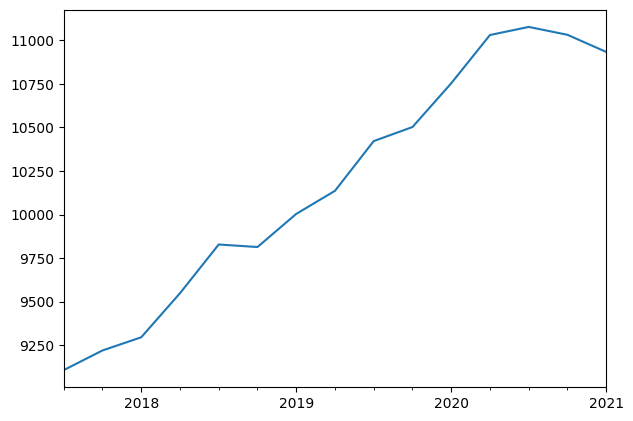

In [44]:
df_train = add_indice_prix(df_train, indice_prix_quarter(model, plot = True))

## Visualisation

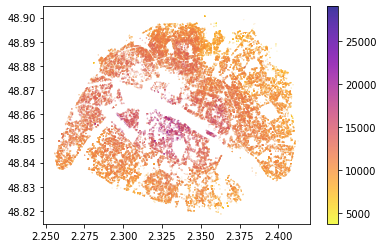

In [21]:
visualise(df, 'Prix_m2')

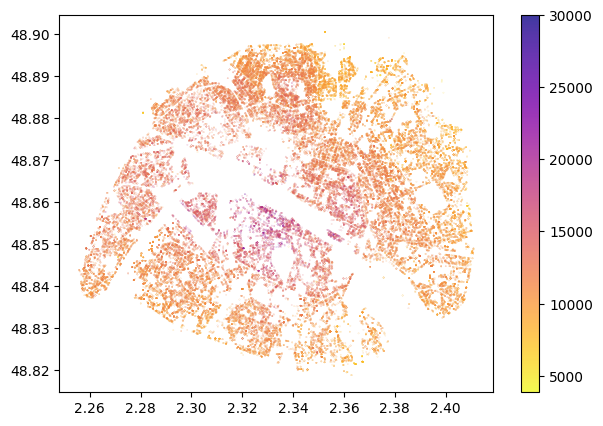

In [22]:
visualise(df_train, 'Prix_m2_actualise_Q1_2021')

## Sélection des features : 

In [47]:
df_test_vif = df[[
        'nombre_pieces_principales','Nombre_dependance','Part_dactifs','dist_metro']]

In [48]:
calc_vif(df_test_vif)

variables       VIF
0  nombre_pieces_principales  4.998924
1          Nombre_dependance  1.422424
2               Part_dactifs  6.644831
3                 dist_metro  3.332721

## <center> K plus proches voisins sur la latitude/longitude

Les features sont : 
- pour le KNN : 
    - latitude; longitude
- pour le Random Forest ou GBoost:
    - à compléter

In [25]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [26]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 13}


In [27]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  10.07643752298031
MDAPE:  7.545547808252347


In [28]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  10.447990116665167
MDAPE:  7.984715735937642


## Etude du score

In [29]:
X_test = df_test.copy()
y_pred = knn_pipe.predict(X_test[features_knn])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100
X_test.head(3)

id_mutation date_mutation  code_type_local  code_commune  \
101  2021-1581950    2021-04-01              2.0         75103   
102  2021-1582387    2021-04-09              2.0         75103   
103  2021-1582391    2021-04-14              2.0         75103   

     surface_terrain  surface_reelle_bati  nombre_pieces_principales  \
101              0.0                 44.0                        3.0   
102              0.0                 45.0                        2.0   
103              0.0                 26.0                        2.0   

    nature_culture  valeur_fonciere   latitude  longitude  nombre_lots  \
101              0         710000.0  48.857902   2.366992            3   
102              0         573000.0  48.857871   2.364699            2   
103              0         377505.0  48.856715   2.367546            2   

     numero_disposition  code_departement  Nombre_unite  Nombre_dependance  \
101                   1                75             1                  0   
102                   1                75             1                  0   
103                   1                75             1                  0   

     Year  num_trimestre  quarter                    geometry  index_right  \
101  2021              2  2021_Q2  POINT (2.366992 48.857902)      17739.0   
102  2021              2  2021_Q2  POINT (2.364699 48.857871)      17739.0   
103  2021              2  2021_Q2  POINT (2.367546 48.856715)      17739.0   

                           epci_name  iris_code      iris_name  \
101  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives    
102  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives    
103  ['MÃÂ©tropole du Grand Paris']  751031102  Les Archives    

        iris_name_l       Prix_m2  Month  Pris_m2_moy_iris          std  \
101  les archives 2  16136.363636      4      11475.289813  6700.767551   
102  les archives 2  12733.333333      4      11475.289813  6700.767551   
103  les archives 2  14519.423077      4      11475.289813  6700.767551   

     Vente_par_iris  Vente_par_iris_tri  N_logements  N_res_ppale  \
101             145                   8       1229.0        962.0   
102             145                   8       1229.0        962.0   
103             145                   8       1229.0        962.0   

     N_res_second  N_vacant  N_maisons  N_apparts  N_proprietaire  \
101         193.0      74.0        0.0     1226.0           328.0   
102         193.0      74.0        0.0     1226.0           328.0   
103         193.0      74.0        0.0     1226.0           328.0   

     N_locataire  DISP_MED19  Ec_maternelle  Ec_elementaire  UU2020    COM  \
101        598.0       41090              0               1     851  75103   
102        598.0       41090              0               1     851  75103   
103        598.0       41090              0               1     851  75103   

     TRIRIS  GRD_QUART TYP_IRIS  P19_POP1564  P19_POP1524  P19_POP2554  \
101  750081    7510311        H  1151.465277   168.611918   792.332141   
102  750081    7510311        H  1151.465277   168.611918   792.332141   
103  750081    7510311        H  1151.465277   168.611918   792.332141   

     P19_POP5564  P19_ACT1564  P19_CHOM1564  P19_INACT1564  Part_dactifs  \
101   190.521218   948.557229     80.312175     202.908048      0.823783   
102   190.521218   948.557229     80.312175     202.908048      0.823783   
103   190.521218   948.557229     80.312175     202.908048      0.823783   

     Part_chomeurs  Arrondissement  dist_metro  dist_metro_dummy  \
101       0.069748           75103    0.001001                 0   
102       0.069748           75103    0.003250                 0   
103       0.069748           75103    0.000934                 0   

     Nombre_dependance_dummy  Ec_maternelle_dummy  Ec_elementaire_dummy  \
101                        0                    0                     1   
102                        0                    0                     1

In [30]:
X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T

Arrondissement      75101     75102     75103     75104     75105      75106  \
mdape           11.064216  9.007546  9.241943  9.211942  8.395176  10.273309   

Arrondissement      75107     75108     75109     75110     75111     75112  \
mdape           10.144153  9.443174  8.136821  7.949931  7.283687  6.860808   

Arrondissement     75113     75114     75115     75116     75117  75118  \
mdape           7.363947  7.378233  7.159096  8.552781  7.715356  8.335   

Arrondissement     75119     75120  
mdape           8.208512  7.761758

In [33]:
fig = px.scatter(X_test, x = 'surface_reelle_bati', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

## Random Forest

In [ ]:
%run '../Helpers/Models.py'

In [53]:
features_RF = ['Nombre_dependance_dummy', 'dist_metro_dummy', 'nombre_pieces_principales',
               #'Ec_elementaire_dummy', 'Ec_maternelle_dummy',
              'N_apparts', 'DISP_MED19', 'Part_chomeurs']

In [54]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [5, 10], nb_cv = 5)

In [55]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  10.445967313995212
MDAPE:  7.987022933154569


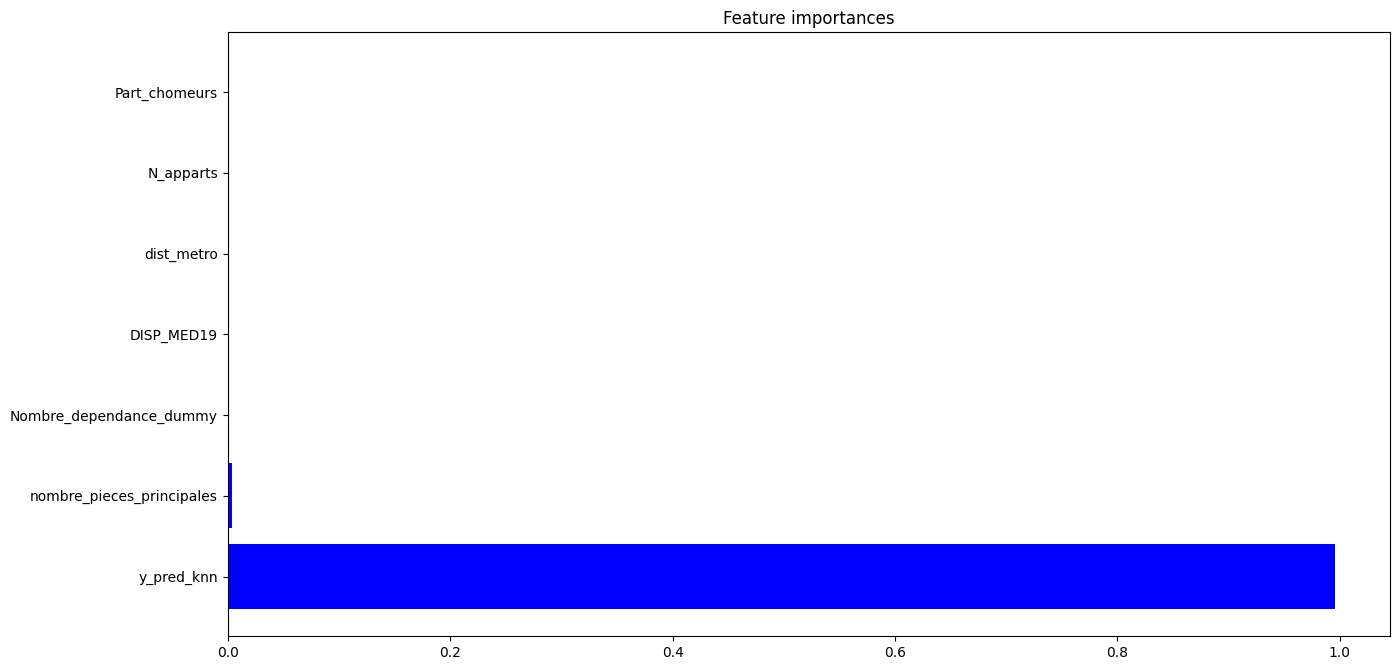

In [56]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

## Gradient Boost

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, y_train)

compute_scores(gboost_pipe, X_test_rf, y_test)

In [ ]:
gboost_pipe.best_params_

In [ ]:
#dummies_pr_var_continues(df, 'dist_metro', 0.01)

**Features importance**

In [ ]:
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_rf.predict(X_test_rf)

importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

XG BOOST

In [ ]:
df_train.columns

In [ ]:
model_gb = GradientBoostingRegressor(n_estimators = 100)
model_gb.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_gb.predict(X_test_rf)

importances = model_gb.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()